# Ćwiczenie 8. Lokalne wyrównywanie histogramu oraz poprawa jakości oparta na lokalnych statystykach

Biblioteki używane dla wykonania tego ćwiczenia:

In [5]:
%matplotlib inline

import numpy as np  
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
from skimage.morphology import disk
from skimage.filters import rank
from skimage import img_as_ubyte
from skimage import exposure

## Ładowanie obrazu

Funkcja *img_as_ubyte()* pochodzi z pakietu skimage i służy do konwersji obrazu do formatu 8-bitowego (uint8, czyli wartości od 0 do 255). Niektóre funkcje w *skimage.filters.rank*, takie jak *rank.mean()* czy *rank.equalize()*, oczekują, że obraz będzie w formacie uint8, bo działają na histogramach z 256 poziomami jasności (czyli 8-bitowych).

In [6]:
file_path = 'ObrazyTestowe/hidden-symbols.tif'
image = np.asarray(Image.open(file_path).convert('L'))
image = img_as_ubyte(image).copy()

## Lokalne wyrównywanie histogramu

Do wykonania lokalnego wyrównywania histogramu używamy funkcji rank.equalize z biblioteki skimage. Przyjmuje ona jako parametry obraz wejściowy oraz tzw. element strukturalny – czyli kształt i rozmiar lokalnej maski. W praktyce disk(1) tworzy maskę o rozmiarze około **3x3**, disk(2) – **5×5**, a disk(3) - około **9x9**.

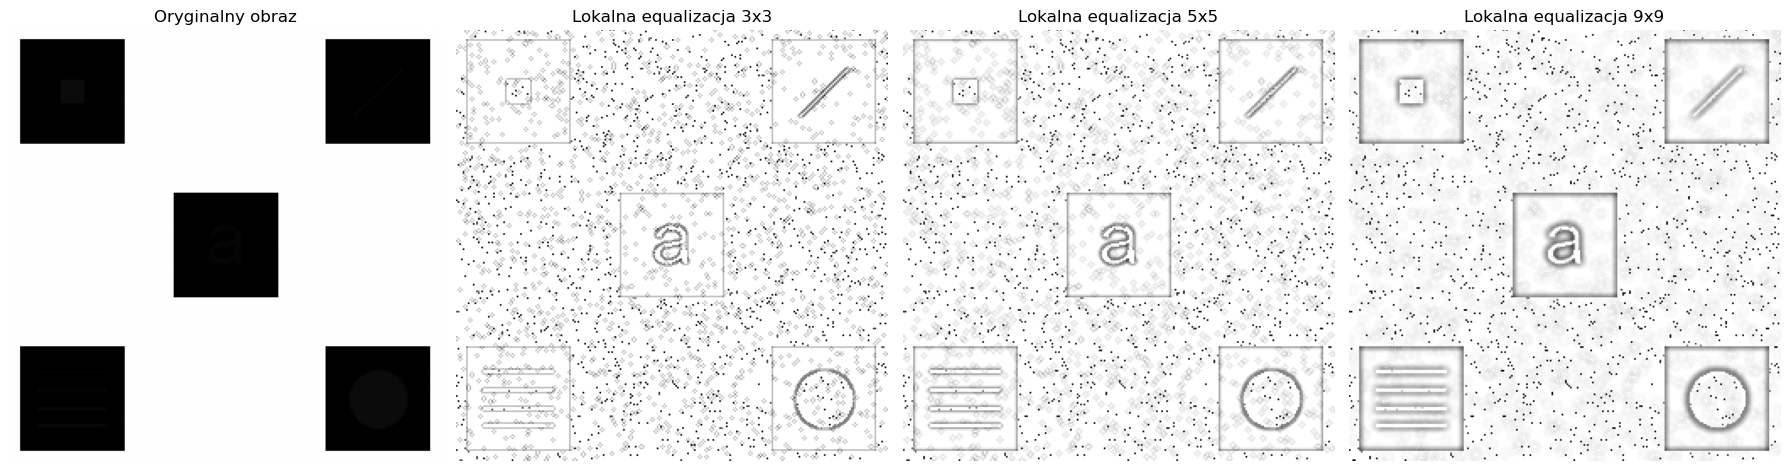

In [7]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Oryginalny obraz')
plt.axis('off')

# 3x3
eq_3 = rank.equalize(image, disk(1))  # disk(1) ≈ 3x3
plt.subplot(1, 4, 2)
plt.imshow(eq_3, cmap='gray')
plt.title('Lokalna equalizacja 3x3')
plt.axis('off')

# 5x5
eq_5 = rank.equalize(image, disk(2))  # disk(2) ≈ 5x5
plt.subplot(1, 4, 3)
plt.imshow(eq_5, cmap='gray')
plt.title('Lokalna equalizacja 5x5')
plt.axis('off')

# 9x9
eq_9 = rank.equalize(image, disk(4))  # disk(4) ≈ 9x9
plt.subplot(1, 4, 4)
plt.imshow(eq_9, cmap='gray')
plt.title('Lokalna equalizacja 9x9')
plt.axis('off')

plt.tight_layout()
plt.show()

## Poprawa jakości oparta na lokalnych statystykach

W tym zadaniu zastosowano metodę poprawy jakości obrazu opartą na lokalnych statystykach, zgodną z teorią przedstawioną na wykładzie *"Transformacje poziomu jasności"*. Celem jest selektywne wzmocnienie fragmentów obrazu, które spełniają określone warunki oparte na lokalnych i globalnych parametrach jasności.

Zmiennym w kodzie odpowiadają następujące oznaczenia matematyczne:

- `local_mean` → $( m_{s_{xy}} $) – lokalna średnia jasności w sąsiedztwie piksela,
- `local_var` → $( \sigma^2_{s_{xy}} $) – lokalna wariancja jasności,
- `local_stddev` → $( \sigma_{s_{xy}} $) – lokalne odchylenie standardowe jasności.

Wszystkie powyższe zostały obliczone za pomocą funkcji z bibliotek **skimage** oraz **NumPy**.

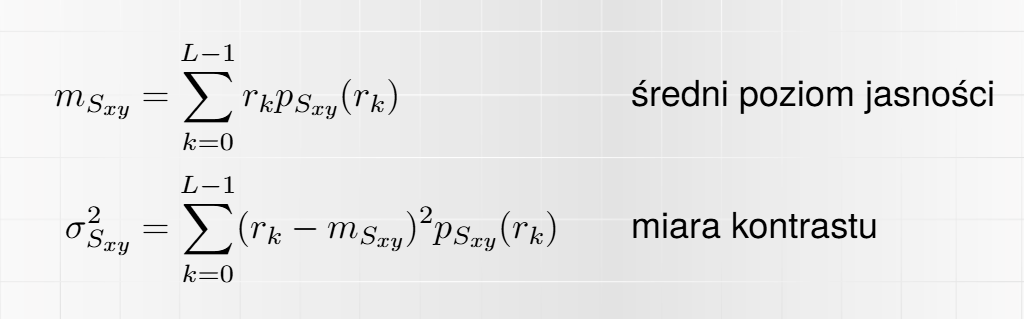

To jest wzór w linii: $( E = mc^2 $)

A to wersja blokowa:

$$
a^2 + b^2 = c^2
$$

Do sprawdzenia, czy dany piksel powinien być wzmocniony, stosowany jest następujący warunek:

- `global_mean` → $( m_G $) – średnia jasność całego obrazu,
- `global_stddev` → $( \sigma_G $) – globalne odchylenie standardowe jasności.

Piksel spełnia warunek, jeśli:

$$
k_0 \cdot m_G \leq m_{s_{xy}} \leq k_1 \cdot m_G
\quad \text{oraz} \quad
k_2 \cdot \sigma_G \leq \sigma_{s_{xy}} \leq k_3 \cdot \sigma_G
$$

Jeśli powyższy warunek jest spełniony, piksel zostaje **wzmocniony** przez przemnożenie jego wartości przez stałą `C`:

$$
f'(x, y) = C \cdot f(x, y)
$$

Po modyfikacji obraz jest **normalizowany** do pełnego zakresu jasności, aby zachować prawidłową prezentację.

Dla porównania testowane są różne rozmiary masek (`mask_size`): `5`, `15`, `30`. Zwiększanie rozmiaru maski powoduje, że lokalne statystyki stają się bardziej uśrednione, co może ograniczyć liczbę pikseli spełniających warunek — przez co efekt wzmocnienia może być słabszy.

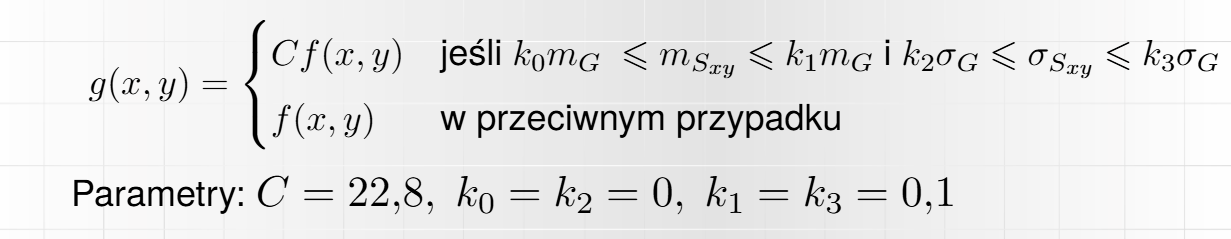

Maska 5: 14580 pikseli spełnia warunek
Maska 15: 7792 pikseli spełnia warunek
Maska 30: 1120 pikseli spełnia warunek


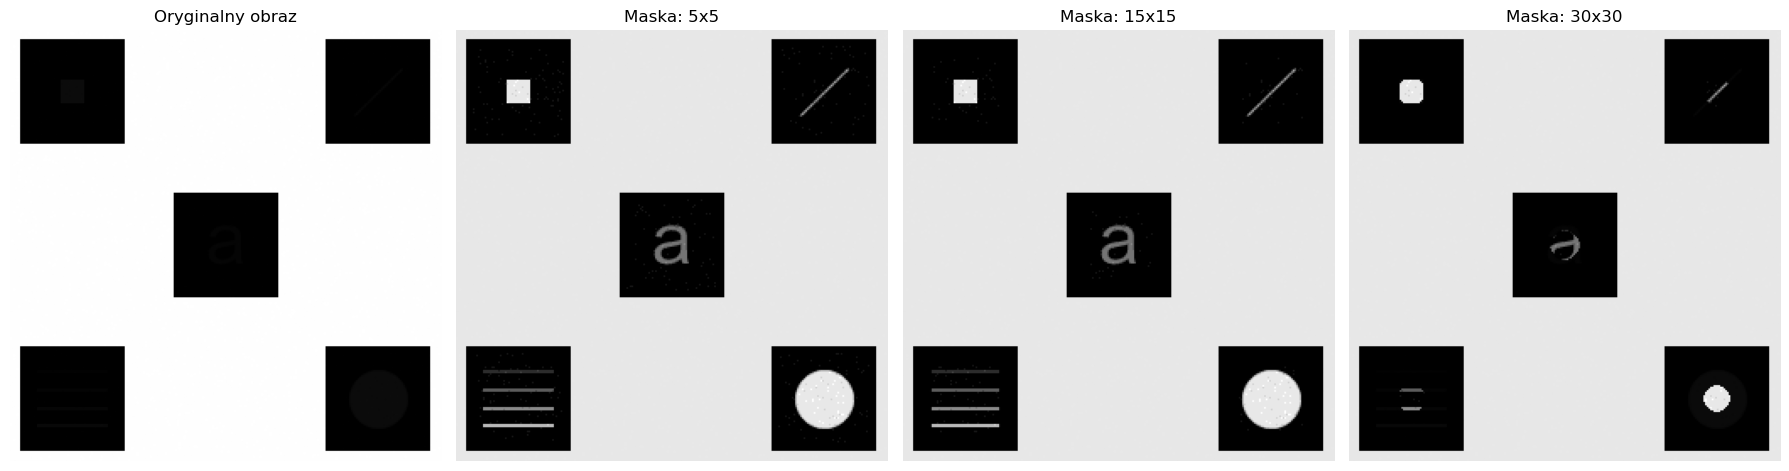

In [18]:
# Parametry jak ze slajdu
C, k0, k1, k2, k3 = 22.8, 0, 0.1, 0, 0.1
mask_sizes = [5, 15, 30]

plt.figure(figsize=(18, 6))

# Oryginalny obraz
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Oryginalny obraz')
plt.axis('off')

for i, mask_size in enumerate(mask_sizes):
    selem = disk(mask_size)

    # Lokalne statystyki
    local_mean = rank.mean(img_as_ubyte(image), selem).astype('float') # m_s_xy
    local_mean_sq = rank.mean(img_as_ubyte(image**2), selem).astype('float') # (σ^2)_s_xy
    local_var = np.clip(local_mean_sq - local_mean**2, 0, None)
    local_stddev = np.sqrt(local_var)

    global_mean = np.mean(image)
    global_stddev = np.std(image)

    # Warunek
    condition = (
        (k0 * global_mean <= local_mean) & (local_mean <= k1 * global_mean) &
        (k2 * global_stddev <= local_stddev) & (local_stddev <= k3 * global_stddev)
    )

    print(f"Maska {mask_size}: {np.sum(condition)} pikseli spełnia warunek")

    # Wzmocnienie tylko w spełnionym warunku
    enhanced_image = image.copy()
    enhanced_image[condition] = C * enhanced_image[condition]

    # Normalizacja
    enhanced_image = exposure.rescale_intensity(enhanced_image, in_range='image')

    plt.subplot(1, 4, i + 2)
    plt.imshow(enhanced_image, cmap='gray')
    plt.title(f'Maska: {mask_size}x{mask_size}')
    plt.axis('off')

plt.tight_layout()
plt.show()